# Applications of Gradient Boosting

This notebook requires `hep_ml`. If you're not using cloud, use 
```
!pip install hep_ml
!pip install rep --no-dependencies
```

## Putting uniformity as a restriction during boosting

In physics, frequently we want a classifier not to rely on some variables (**spectators**): mass, lifetime, Dalitz variables.

In certain situations we don't want to use gender and race. 
I.e. if you're hiring programmers, you have information about good programmers in your company and you're scanning for similar people among facebook accounts. Of course, a classifier will heavily rely on gender. If you simply exclude the gender from information, this is not of much help, since the classifier can easily reconstruct that from texts and other information on facebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import root_numpy
import pandas

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

## Load the data
Dataset is anonymized, so no names of features and spectators. There is strong dependence between spectators and features. These data by their behaviour simulate situation of PID problem in HEP: features are likelihoods in which momentum and transverse momentum are involved; spectators are momentum and transverse momentum.

In [2]:
data = pandas.DataFrame(root_numpy.root2array('datasets/flatness.root'))
train, test = train_test_split(data, random_state=11, train_size=0.66)

In [3]:
data.head()

,target,feature_1,feature_2,feature_3,feature_4,feature_5,spectator_1,spectator_2
0,0,1.110926,0.059254,-1.225864,-1.259084,-3.165156,0.557775,0.743700
1,0,1.207733,-1.151443,0.776845,1.192667,0.914127,0.381225,0.614750
2,0,2.433588,0.090613,0.160547,0.137861,-0.961502,0.568200,0.356300
3,0,1.271362,-0.692219,0.454526,0.434673,1.501989,0.028275,0.290950
4,0,3.215980,0.077155,1.451107,1.490663,0.258074,0.362825,0.285875


In [4]:
all_features = list(set(data.columns) - {'target'})
features = list(set(data.columns) - {'target', 'spectator_1', 'spectator_2'})

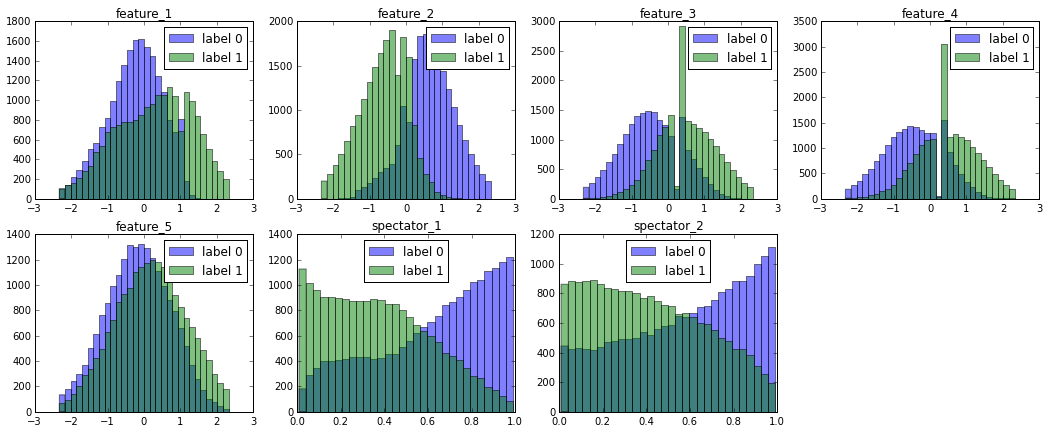

In [5]:
plt.figure(figsize=[18, 7])
for i, column in enumerate(data.columns):
    if column == 'target':
        continue
    plt.subplot(2, 4, i)
    plt.title(column)
    x_range = numpy.percentile(data[column], [1, 99])
    plt.hist(data.ix[data.target.values == 1, column].values, range=x_range, bins=30, alpha=0.5, label='label 0')
    plt.hist(data.ix[data.target.values == 0, column].values, range=x_range, bins=30, alpha=0.5, label='label 1')
    plt.legend(loc='best')

In [6]:
# define simple function to compute efficiencies along the spectator for fixed signal efficiency
from rep.plotting import ErrorPlot
from rep.utils import weighted_quantile, get_efficiencies

def plot_flatness(target, probs, spectator, thresholds=[20, 40, 50, 60, 80], class_label=1, spectator_name='spectator'):
    probs = probs[target == class_label]
    spectator = spectator[target == class_label]
    thresholds_values = [weighted_quantile(probs, quantiles=1 - eff / 100.) for eff in thresholds]
    eff = get_efficiencies(probs, spectator,  bins_number=20, errors=True, ignored_sideband=0.01,
                           thresholds=thresholds_values, sample_weight=numpy.ones(len(probs)))
    for thr in thresholds_values:
        eff[thr] = (eff[thr][0], 100 * numpy.array(eff[thr][1]), 100 * numpy.array(eff[thr][2]), eff[thr][3])
    plot_fig = ErrorPlot(eff)
    plot_fig.ylabel = 'Efficiency'
    plot_fig.xlabel = spectator_name
    plot_fig.ylim = (0, 100)
    plot_fig.plot(fontsize=22)
    plt.xticks(fontsize=12), plt.yticks(fontsize=12)
    plt.legend(map(str, thresholds), loc='best')

In [7]:
# define function to compute CvM for different spectators and the ROC AUC score
from hep_ml.metrics import KnnBasedCvM

def compute_metrics(data, probs):
    print 'ROC AUC score:', '{:7}'.format(roc_auc_score(test.target, probs[:, 1]))
    generate_cvm_metric = lambda x: KnnBasedCvM(x, uniform_label=1).fit(data, data.target)
    for variables in (['spectator_1'], ['spectator_2'], ['spectator_1', 'spectator_2']):
        print 'CvM metric:   ', 
        print '{:7}'.format(generate_cvm_metric(variables)(data.target.values, probs, numpy.ones(len(probs)))),
        print 'over', ', '.join(variables) 

### Simple training of GB on all features 

In [8]:
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=6, subsample=0.7,
                                min_samples_split=500, min_samples_leaf=50)
gb.fit(train[all_features], train.target)

GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=0.7, verbose=0,
              warm_start=False)

In [9]:
gb_proba = gb.predict_proba(test[all_features])
# compute CvM on the test sample as a flatness measure and compute ROC AUC
compute_metrics(test, gb_proba)

ROC AUC score: 0.97668394197
CvM metric:    0.0524765214813 over spectator_1
CvM metric:    0.0353476556561 over spectator_2
CvM metric:    0.068136094805 over spectator_1, spectator_2


/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


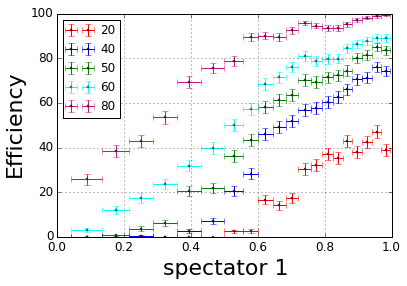

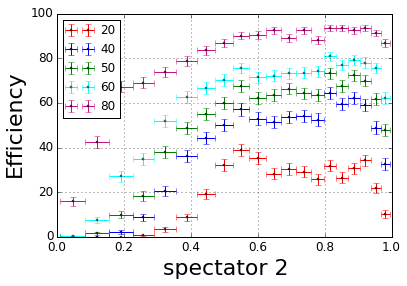

In [10]:
# plot flatness along both spectators
plot_flatness(test.target.values, gb_proba[:, 1], test.spectator_1.values, spectator_name='spectator 1')
plt.show()
plot_flatness(test.target.values, gb_proba[:, 1], test.spectator_2.values, spectator_name='spectator 2')

**Exercise #1.** Remove spectator features. Does quality decrease? Does CvM become smaller? Plot effeciencies along the spectators. Do they become more flat?

ROC AUC score: 0.970572069
CvM metric:    0.0267275329823 over spectator_1
CvM metric:    0.0338040751983 over spectator_2
CvM metric:    0.0490013293998 over spectator_1, spectator_2


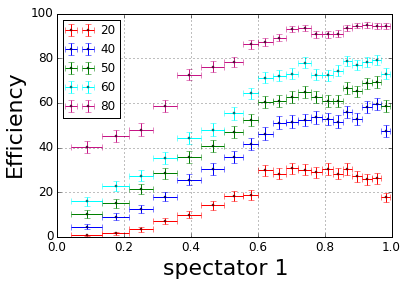

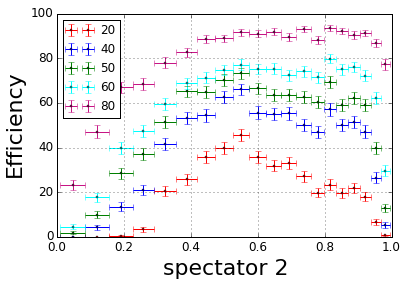

In [11]:
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=6, subsample=0.7,
                                min_samples_split=500, min_samples_leaf=50)
gb.fit(train[features], train.target)
gb_proba = gb.predict_proba(test[features])
# compute CvM on the test sample as a flatness measure and compute ROC AUC
compute_metrics(test, gb_proba)
plot_flatness(test.target.values, gb_proba[:, 1], test.spectator_1.values, spectator_name='spectator 1')
plt.show()
plot_flatness(test.target.values, gb_proba[:, 1], test.spectator_2.values, spectator_name='spectator 2')

**Exercise #2.** Tune parameters to obtain the best quality, but maybe poor flatness (high CvM). Tune the parameters/features to obtain the smallest CvM.

In [17]:
from sklearn.grid_search import GridSearchCV

grid = {'learning_rate' : [0.05, 0.1, 0.2], 'n_estimators': [300,500,800], 'max_depth':[4,6,8], 'subsample':[0.7],
                                'min_samples_split':[500], 'min_samples_leaf':[50]}
clf = GridSearchCV(GradientBoostingClassifier(), grid, scoring='roc_auc')
best = clf.fit(train[all_features], train.target)


KeyboardInterrupt: 

### uGB+FL

In [12]:
%%time
from hep_ml.gradientboosting import UGradientBoostingClassifier, BinFlatnessLossFunction
# we say that loss function should contain a term to penalize for non-uniformity in spectator 1
loss = BinFlatnessLossFunction(uniform_features=['spectator_1'], uniform_label=1, n_bins=10, fl_coefficient=5)
# we also put all features for the exception of mass to use in training
flat_gb = UGradientBoostingClassifier(loss=loss, train_features=all_features, min_samples_leaf=100, 
                                      learning_rate=0.1, max_depth=6, 
                                      subsample=0.7, n_estimators=200) 
flat_gb.fit(train, train.target)

CPU times: user 16.6 s, sys: 2.99 ms, total: 16.6 s
Wall time: 16.6 s


In [13]:
# test quality on the test sample
flat_gb_proba = flat_gb.predict_proba(test)
compute_metrics(test, flat_gb_proba)

ROC AUC score: 0.967438591424
CvM metric:    0.00673454637672 over spectator_1
CvM metric:    0.0142126055466 over spectator_2
CvM metric:    0.0205928350502 over spectator_1, spectator_2


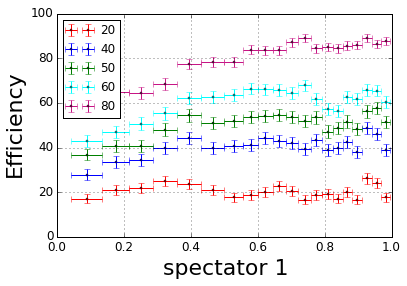

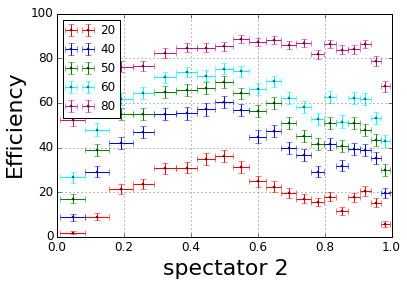

In [14]:
# plot flatness along both spectators
plot_flatness(test.target.values, flat_gb_proba[:, 1], test.spectator_1.values, spectator_name='spectator 1')
plt.show()
plot_flatness(test.target.values, flat_gb_proba[:, 1], test.spectator_2.values, spectator_name='spectator 2')

**Exercise #3.** Vary flatness loss coefficient in the loss and plot the dependence between it and the ROC AUC score (10 points is enough). Investigate flat model for the second spectator `spectator_2`

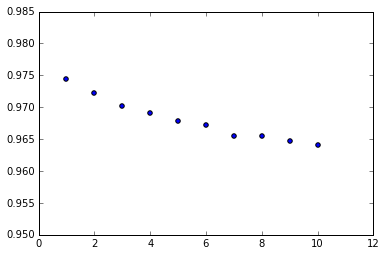

In [16]:
from hep_ml.gradientboosting import UGradientBoostingClassifier, BinFlatnessLossFunction

losses = numpy.arange(10)+1
scores = []
for fl in losses:
    # we say that loss function should contain a term to penalize for non-uniformity in spectator 1
    loss = BinFlatnessLossFunction(uniform_features=['spectator_1'], uniform_label=1, n_bins=10, fl_coefficient=fl)
    # we also put all features for the exception of mass to use in training
    flat_gb = UGradientBoostingClassifier(loss=loss, train_features=all_features, min_samples_leaf=100, 
                                          learning_rate=0.1, max_depth=6, 
                                          subsample=0.7, n_estimators=200) 
    flat_gb.fit(train, train.target)
    flat_gb_proba = flat_gb.predict_proba(test)
    scores.append(roc_auc_score(test.target, flat_gb_proba[:, 1]))

plt.scatter(losses, scores)


ROC AUC score: 0.970022306878
CvM metric:    0.026326096862 over spectator_1
CvM metric:    0.00710872220273 over spectator_2
CvM metric:    0.0405473686279 over spectator_1, spectator_2


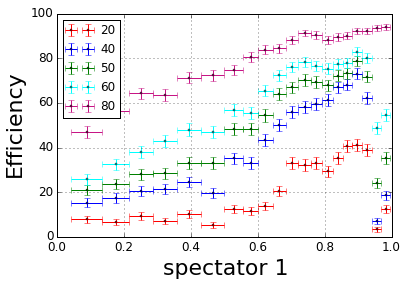

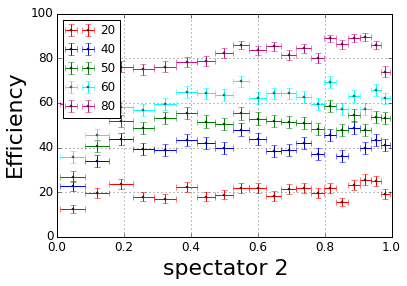

In [18]:
from hep_ml.gradientboosting import UGradientBoostingClassifier, BinFlatnessLossFunction
# we say that loss function should contain a term to penalize for non-uniformity in spectator 1
loss = BinFlatnessLossFunction(uniform_features=['spectator_2'], uniform_label=1, n_bins=10, fl_coefficient=5)
# we also put all features for the exception of mass to use in training
flat_gb = UGradientBoostingClassifier(loss=loss, train_features=all_features, min_samples_leaf=100, 
                                      learning_rate=0.1, max_depth=6, 
                                      subsample=0.7, n_estimators=200) 
flat_gb.fit(train, train.target)
flat_gb_proba = flat_gb.predict_proba(test)
compute_metrics(test, flat_gb_proba)
# plot flatness along both spectators
plot_flatness(test.target.values, flat_gb_proba[:, 1], test.spectator_1.values, spectator_name='spectator 1')
plt.show()
plot_flatness(test.target.values, flat_gb_proba[:, 1], test.spectator_2.values, spectator_name='spectator 2')

**Exercise #4.** Use the custom loss (sum of two flatness losses for both spectators, the loss is defined below) to obtain a flat model along the both spectators. Compare this result with 2d flatness loss optimization (put both spectators into the loss: `BinFlatnessLossFunction(uniform_features=['spectator_1', 'spectator_2'])`)

ROC AUC score: 0.966327551175
CvM metric:    0.00852398531588 over spectator_1
CvM metric:    0.00637535203172 over spectator_2
CvM metric:    0.00860545313681 over spectator_1, spectator_2


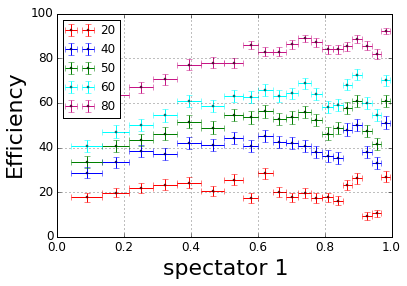

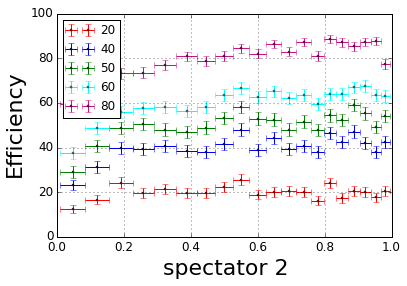

In [19]:
from hep_ml.gradientboosting import UGradientBoostingClassifier, BinFlatnessLossFunction
# we say that loss function should contain a term to penalize for non-uniformity in spectator 1
loss = BinFlatnessLossFunction(uniform_features=['spectator_1', 'spectator_2'], uniform_label=1, n_bins=10, fl_coefficient=5)
# we also put all features for the exception of mass to use in training
flat_gb = UGradientBoostingClassifier(loss=loss, train_features=all_features, min_samples_leaf=100, 
                                      learning_rate=0.1, max_depth=6, 
                                      subsample=0.7, n_estimators=200) 
flat_gb.fit(train, train.target)
flat_gb_proba = flat_gb.predict_proba(test)
compute_metrics(test, flat_gb_proba)
# plot flatness along both spectators
plot_flatness(test.target.values, flat_gb_proba[:, 1], test.spectator_1.values, spectator_name='spectator 1')
plt.show()
plot_flatness(test.target.values, flat_gb_proba[:, 1], test.spectator_2.values, spectator_name='spectator 2')

In [ ]:
from hep_ml.losses import AbstractLossFunction

# define sum of two flatness losses because of high correlation between two spectators
class SumFlatLossFunction(AbstractLossFunction):
    """
    Compute loss separately for two variables (in our context for track Pt and track P):
    Loss = [Loss(spectator 1) + Loss(spectator 2)] / 2
    """
    def __init__(self, spectator1_loss, spectator2_loss):
        self.spectator1_loss = spectator1_loss
        self.spectator2_loss = spectator2_loss
        
    def fit(self, X, y, sample_weight):
        self.spectator1_loss.fit(X, y, sample_weight)
        self.spectator2_loss.fit(X, y, sample_weight)
        return self

    def __call__(self, y_pred):
        return (self.spectator1_loss(y_pred) + self.spectator1_loss(y_pred)) / 2.

    def negative_gradient(self, y_pred):
        return (self.spectator1_loss.negative_gradient(y_pred) + self.spectator2_loss.negative_gradient(y_pred)) / 2.

    def prepare_tree_params(self, y_pred):
        return (self.spectator1_loss.negative_gradient(y_pred) + self.spectator2_loss.negative_gradient(y_pred)) / 2., \
               numpy.ones(len(y_pred))
        
from hep_ml.gradientboosting import UGradientBoostingClassifier, BinFlatnessLossFunction
# we say that loss function should contain a term to penalize for non-uniformity in spectator 1
loss = BinFlatnessLossFunction(uniform_features=['spectator_1', 'spectator_2'], uniform_label=1, n_bins=10, fl_coefficient=5)
# we also put all features for the exception of mass to use in training
flat_gb = UGradientBoostingClassifier(loss=loss, train_features=all_features, min_samples_leaf=100, 
                                      learning_rate=0.1, max_depth=6, 
                                      subsample=0.7, n_estimators=200) 
flat_gb.fit(train, train.target)
flat_gb_proba = flat_gb.predict_proba(test)
compute_metrics(test, flat_gb_proba)
# plot flatness along both spectators
plot_flatness(test.target.values, flat_gb_proba[:, 1], test.spectator_1.values, spectator_name='spectator 1')
plt.show()
plot_flatness(test.target.values, flat_gb_proba[:, 1], test.spectator_2.values, spectator_name='spectator 2')

**Exercise #5.**(optional) Can you construct uGB+FL model with the same quality for GB which is trained without spectator features? Do these two models have the same flatness property?

In [14]:
from hep_ml.losses import AbstractLossFunction

# define sum of two flatness losses because of high correlation between two spectators
class SumFlatLossFunction(AbstractLossFunction):
    """
    Compute loss separately for two variables (in our context for track Pt and track P):
    Loss = [Loss(spectator 1) + Loss(spectator 2)] / 2
    """
    def __init__(self, spectator1_loss, spectator2_loss):
        self.spectator1_loss = spectator1_loss
        self.spectator2_loss = spectator2_loss
        
    def fit(self, X, y, sample_weight):
        self.spectator1_loss.fit(X, y, sample_weight)
        self.spectator2_loss.fit(X, y, sample_weight)
        return self

    def __call__(self, y_pred):
        return (self.spectator1_loss(y_pred) + self.spectator1_loss(y_pred)) / 2.

    def negative_gradient(self, y_pred):
        return (self.spectator1_loss.negative_gradient(y_pred) + self.spectator2_loss.negative_gradient(y_pred)) / 2.

    def prepare_tree_params(self, y_pred):
        return (self.spectator1_loss.negative_gradient(y_pred) + self.spectator2_loss.negative_gradient(y_pred)) / 2., \
               numpy.ones(len(y_pred))